# ADS 509 Module 3: Group Comparison 

The task of comparing two groups of text is fundamental to textual analysis. There are innumerable applications: survey respondents from different segments of customers, speeches by different political parties, words used in Tweets by different constituencies, etc. In this assignment you will build code to effect comparisons between groups of text data, using the ideas learned in reading and lecture.

This assignment asks you to analyze the lyrics and Twitter descriptions for the two artists you selected in Module 1. If the results from that pull were not to your liking, you are welcome to use the zipped data from the “Assignment Materials” section. Specifically, you are asked to do the following: 

* Read in the data, normalize the text, and tokenize it. When you tokenize your Twitter descriptions, keep hashtags and emojis in your token set. 
* Calculate descriptive statistics on the two sets of lyrics and compare the results. 
* For each of the four corpora, find the words that are unique to that corpus. 
* Build word clouds for all four corpora. 

Each one of the analyses has a section dedicated to it below. Before beginning the analysis there is a section for you to read in the data and do your cleaning (tokenization and normalization). 


## General Assignment Instructions

These instructions are included in every assignment, to remind you of the coding standards for the class. Feel free to delete this cell after reading it. 

One sign of mature code is conforming to a style guide. We recommend the [Google Python Style Guide](https://google.github.io/styleguide/pyguide.html). If you use a different style guide, please include a cell with a link. 

Your code should be relatively easy-to-read, sensibly commented, and clean. Writing code is a messy process, so please be sure to edit your final submission. Remove any cells that are not needed or parts of cells that contain unnecessary code. Remove inessential `import` statements and make sure that all such statements are moved into the designated cell. 

Make use of non-code cells for written commentary. These cells should be grammatical and clearly written. In some of these cells you will have questions to answer. The questions will be marked by a "Q:" and will have a corresponding "A:" spot for you. *Make sure to answer every question marked with a `Q:` for full credit.* 


In [14]:
import os
import re
import emoji
import pandas as pd

from collections import Counter, defaultdict
from nltk.corpus import stopwords
from string import punctuation
from wordcloud import WordCloud 

from sklearn.feature_extraction.text import TfidfTransformer, CountVectorizer


In [15]:
# Use this space for any additional import statements you need
import nltk
from nltk.probability import FreqDist
from nltk.tokenize import word_tokenize
import copy
import matplotlib as plt
from collections import Counter
from matplotlib import pyplot as plt

import os
from collections import defaultdict

In [16]:
# Place any addtional functions or constants you need here. 


# Some punctuation variations
punctuation = set(punctuation) # speeds up comparison
tw_punct = punctuation - {"#"}

# Stopwords
sw = stopwords.words("english")
sw_no_punct = [word.replace("'", "")for word in sw]

# Two useful regex
whitespace_pattern = re.compile(r"\s+")
hashtag_pattern = re.compile(r"^#[0-9a-zA-Z]+")

# It's handy to have a full set of emojis
all_language_emojis = set()

for country in emoji.EMOJI_DATA : 
    for em in emoji.EMOJI_DATA[country] : 
        all_language_emojis.add(em)

# and now our functions
def descriptive_stats(tokens, num_tokens = 5, verbose=True) :
    # Fill in the correct values here. 
    num_tokens = len(tokens)
    num_unique_tokens = len(set(tokens))
    lexical_diversity = num_unique_tokens / num_tokens
    num_characters = sum(len(token) for token in tokens)
    
    if verbose :        
        print(f"There are {num_tokens} tokens in the data.")
        print(f"There are {num_unique_tokens} unique tokens in the data.")
        print(f"There are {num_characters} characters in the data.")
        print(f"The lexical diversity is {lexical_diversity:.3f} in the data.")
    
        # print the five most common tokens
        fdist = FreqDist(tokens)
        print(f"The {num_tokens} most common tokens are:")
        for token, frequency in fdist.most_common(num_tokens)[:5]:
            print(f"{token}: {frequency}")
        
    return([num_tokens, num_unique_tokens,
            lexical_diversity,
            num_characters
            ])


    
def contains_emoji(s):
    
    s = str(s)
    emojis = [ch for ch in s if emoji.is_emoji(ch)]

    return(len(emojis) > 0)


def remove_stop(tokens) :
    # modify this function to remove stopwords
    return(tokens)
 
def remove_punctuation(text, punct_set=tw_punct) : 
    return("".join([ch for ch in text if ch not in punct_set]))

# Splitting on whitespace rather than the book's tokenize function. That 
# function will drop tokens like '#hashtag' or '2A', which we need for Twitter. """
def tokenize(text):
    
    # Split the text into tokens using whitespace as the delimiter
    #tokens = text.split()
    
    # Return the tokens and the modified text
    #return tokens, ' '.join(tokens)
    return(text.split())

def prepare(text, pipeline) : 
    tokens = str(text)
    
    for transform in pipeline : 
        tokens = transform(tokens)
        
    return(tokens)


## Data Ingestion

Use this section to ingest your data into the data structures you plan to use. Typically this will be a dictionary or a pandas DataFrame.

In [17]:
# Feel fre to use the below cells as an example or read in the data in a way you prefer

# change `data_location` to the location of the folder on your machine.
data_location = "/Users/summerpurschke/Desktop/ADS/ADS509/Mod2"

# These subfolders should still work if you correctly stored the 
# data from the Module 1 assignment
twitter_folder = "/twitter/"
lyrics_folder = "/lyrics/"

artist_files = {'cher':'cher_followers_data.txt',
                'robyn':'robynkonichiwa_followers_data.txt'}


In [18]:
twitter_data = pd.read_csv(data_location + twitter_folder + artist_files['cher'],
                           sep="\t",
                           quoting=3)

twitter_data['artist'] = "cher"

In [19]:
twitter_data_2 = pd.read_csv(data_location + twitter_folder + artist_files['robyn'],
                             sep="\t",
                             quoting=3)

twitter_data_2['artist'] = "robyn"

twitter_data = pd.concat([
    twitter_data,twitter_data_2])
    
del(twitter_data_2)

In [20]:
twitter_data = twitter_data[['artist', 'description']]
twitter_data.head(2)

,artist,description
0,cher,NaN
1,cher,𝙿𝚛𝚘𝚞𝚍 𝚜𝚞𝚙𝚙𝚘𝚛𝚝𝚎𝚛 𝚘𝚏 𝚖𝚎𝚜𝚜𝚢 𝚋𝚞𝚗𝚜 & 𝚕𝚎𝚐𝚐𝚒𝚗𝚐𝚜


Read in Lyrics Data 

In [21]:
def create_lyrics_dictionary(folder_path):
    lyrics_dict = {}

    # Iterate over each item in the folder
    for item_name in os.listdir(folder_path):
        item_path = os.path.join(folder_path, item_name)

        # Check if the item is a folder (artist folder)
        if os.path.isdir(item_path):
            artist_dict = {}

            # Iterate over each file in the artist folder
            for filename in os.listdir(item_path):
                file_path = os.path.join(item_path, filename)

                # Check if the item is a file (song file)
                if os.path.isfile(file_path):
                    with open(file_path, "r") as file:
                        # Read the contents of the file
                        lines = file.readlines()

                        if lines:
                            title = lines[0].strip()  # Assuming the first line contains the title
                            lyrics = ''.join(lines[1:])  # Combine the remaining lines as the lyrics

                            # Add the song lyrics to the artist's dictionary with the title as the inner key
                            artist_dict[title] = lyrics

            # Add the artist's dictionary to the main lyrics dictionary
            lyrics_dict[item_name] = artist_dict

    return lyrics_dict

# Call the function with the lyrics folder path
lyrics_dictionary = create_lyrics_dictionary(data_location + lyrics_folder)

Read in Twitter Data

In [22]:
# twitter_files = os.listdir(data_location + twitter_folder)
# desc_files = [f for f in twitter_files if "followers_data" in f]
# twitter_data = defaultdict(list)

# for f in desc_files:
#     artist = f.split("_")[0]

#     with open(data_location + twitter_folder + f, 'r', encoding='utf-8', errors='ignore') as infile:
#         next(infile)
#         for idx, line in enumerate(infile.readlines()):
#             line = line.strip().split("\t")
#             if len(line) == 7:
#                 twitter_data[artist].append(line[6])

# twitter_data = dict(twitter_data)

## Tokenization and Normalization

In this next section, tokenize and normalize your data. We recommend the following cleaning. 

**Lyrics** 

* Remove song titles
* Casefold to lowercase
* Remove stopwords (optional)
* Remove punctuation
* Split on whitespace

Removal of stopwords is up to you. Your descriptive statistic comparison will be different if you include stopwords, though TF-IDF should still find interesting features for you. Note that we remove stopwords before removing punctuation because the stopword set includes punctuation.

**Twitter Descriptions** 

* Casefold to lowercase
* Remove stopwords
* Remove punctuation other than emojis or hashtags
* Split on whitespace

Removing stopwords seems sensible for the Twitter description data. Remember to leave in emojis and hashtags, since you analyze those. 

In [23]:
# apply the `pipeline` techniques from BTAP Ch 1 or 5

my_pipeline = [str.lower, remove_punctuation, tokenize, remove_stop]

# Create a df from lyrics
#lyrics_data["tokens"] = lyrics_data["lyrics"].apply(prepare,pipeline=my_pipeline)
#lyrics_data["num_tokens"] = lyrics_data["tokens"].map(len) 

twitter_data["tokens"] = twitter_data["description"].apply(prepare,pipeline=my_pipeline)
twitter_data["num_tokens"] = twitter_data["tokens"].map(len) 


In [24]:
twitter_data['has_emoji'] = twitter_data["description"].apply(contains_emoji)

Let's take a quick look at some descriptions with emojis.

In [25]:
twitter_data[twitter_data.has_emoji].sample(10)[["artist","description","tokens"]]

,artist,description,tokens
2488749,cher,•12 years old :3. •Hakuna Matata :) •iceskatin...,"[•12, years, old, 3, •hakuna, matata, •iceskat..."
1069448,cher,(☝︎ ՞ਊ ՞)☝︎,"[☝︎, ՞ਊ, ՞☝︎]"
370979,cher,Still I rise☀️ Pisces🌞 Libra⬆️ Virgo🌛,"[still, i, rise☀️, pisces🌞, libra⬆️, virgo🌛]"
1231949,cher,"real life angel 🤍🏹💌| ♈︎☉, ♈︎ ☾, ♌︎↑ |","[real, life, angel, 🤍🏹💌, ♈︎☉, ♈︎, ☾, ♌︎↑]"
582106,cher,Careers Advisor and Secondary Teacher 😊,"[careers, advisor, and, secondary, teacher, 😊]"
1199606,cher,Lol 🐢,"[lol, 🐢]"
327605,cher,"Lover of older bands, especially Queen, Led Ze...","[lover, of, older, bands, especially, queen, l..."
2585740,cher,wes 🦒 i learned all my shapes from taco bell,"[wes, 🦒, i, learned, all, my, shapes, from, ta..."
3754272,cher,Follow your ❤️ follow your dreams and follow m...,"[follow, your, ❤️, follow, your, dreams, and, ..."
989996,cher,be happy 🌸,"[be, happy, 🌸]"


With the data processed, we can now start work on the assignment questions. 

Q: What is one area of improvement to your tokenization that you could theoretically carry out? (No need to actually do it; let's not make perfect the enemy of good enough.)

A: 

## Calculate descriptive statistics on the two sets of lyrics and compare the results. 


In [ ]:
import pandas as pd
from collections import Counter

def compare_lyrics_statistics(df1, col1, df2, col2):
    """
    Compare descriptive statistics on two sets of lyrics.

    Args:
        df1 (DataFrame): The first DataFrame containing the lyrics column.
        col1 (str): The name of the column with lyrics tokens in df1.
        df2 (DataFrame): The second DataFrame containing the lyrics column.
        col2 (str): The name of the column with lyrics tokens in df2.

    Returns:
        dict: A dictionary containing the following statistics:
            - total_words1: Total number of words in the first set of lyrics.
            - total_words2: Total number of words in the second set of lyrics.
            - unique_words1: Total number of unique words in the first set of lyrics.
            - unique_words2: Total number of unique words in the second set of lyrics.
            - most_common_words1: List of the most common words in the first set of lyrics and their frequencies.
            - most_common_words2: List of the most common words in the second set of lyrics and their frequencies.
            - avg_tokens1: Average number of tokens in the first set of lyrics.
            - avg_tokens2: Average number of tokens in the second set of lyrics.
            - min_tokens1: Minimum number of tokens in the first set of lyrics.
            - min_tokens2: Minimum number of tokens in the second set of lyrics.
            - max_tokens1: Maximum number of tokens in the first set of lyrics.
            - max_tokens2: Maximum number of tokens in the second set of lyrics.
    """
    # Compile all tokens for each column into a body of text for comparison
    lyrics1 = ' '.join(df1[col1].explode().dropna())
    lyrics2 = ' '.join(df2[col2].explode().dropna())

    # Calculate statistics for the first set of lyrics
    tokens1 = lyrics1.split()
    total_words1 = len(tokens1)
    unique_words1 = len(set(tokens1))
    word_counts1 = Counter(tokens1)
    most_common_words1 = word_counts1.most_common()
    avg_tokens1 = total_words1 / len(df1)
    min_tokens1 = min(len(tokens) for tokens in df1[col1])
    max_tokens1 = max(len(tokens) for tokens in df1[col1])

    # Calculate statistics for the second set of lyrics
    tokens2 = lyrics2.split()
    total_words2 = len(tokens2)
    unique_words2 = len(set(tokens2))
    word_counts2 = Counter(tokens2)
    most_common_words2 = word_counts2.most_common()
    avg_tokens2 = total_words2 / len(df2)
    min_tokens2 = min(len(tokens) for tokens in df2[col2])
    max_tokens2 = max(len(tokens) for tokens in df2[col2])

    # Return the statistics as a dictionary
    return {
        'total_words1': total_words1,
        'total_words2': total_words2,
        'unique_words1': unique_words1,
        'unique_words2': unique_words2,
        'most_common_words1': most_common_words1,
        'most_common_words2': most_common_words2,
        'avg_tokens1': avg_tokens1,
        'avg_tokens2': avg_tokens2,
        'min_tokens1': min_tokens1,
        'min_tokens2': min_tokens2,
        'max_tokens1': max_tokens1,
        'max_tokens2': max_tokens1}

Q: what observations do you make about these data? 

A: 


## Find tokens uniquely related to a corpus

Typically we would use TF-IDF to find unique tokens in documents. Unfortunately, we either have too few documents (if we view each data source as a single document) or too many (if we view each description as a separate document). In the latter case, our problem will be that descriptions tend to be short, so our matrix would be too sparse to support analysis. 

To avoid these problems, we will create a custom statistic to identify words that are uniquely related to each corpus. The idea is to find words that occur often in one corpus and infrequently in the other(s). Since corpora can be of different lengths, we will focus on the _concentration_ of tokens within a corpus. "Concentration" is simply the count of the token divided by the total corpus length. For instance, if a corpus had length 100,000 and a word appeared 1,000 times, then the concentration would be $\frac{1000}{100000} = 0.01$. If the same token had a concentration of $0.005$ in another corpus, then the concentration ratio would be $\frac{0.01}{0.005} = 2$. Very rare words can easily create infinite ratios, so you will also add a cutoff to your code so that a token must appear at least $n$ times for you to return it. 

An example of these calculations can be found in [this spreadsheet](https://docs.google.com/spreadsheets/d/1P87fkyslJhqXFnfYezNYrDrXp_GS8gwSATsZymv-9ms). Please don't hesitate to ask questions if this is confusing. 

In this section find 10 tokens for each of your four corpora that meet the following criteria: 

1. The token appears at least `n` times in all corpora
1. The tokens are in the top 10 for the highest ratio of appearances in a given corpora vs appearances in other corpora.

You will choose a cutoff for yourself based on the side of the corpus you're working with. If you're working with the Robyn-Cher corpora provided, `n=5` seems to perform reasonably well.

In [26]:
twitter_data_cher = twitter_data.loc[twitter_data['artist'] == 'cher']
twitter_data_robyn= twitter_data.loc[twitter_data['artist'] == 'robyn']

# lyrics_data_cher = lyrics_data.loc[lyrics_data['artist'] == 'cher']
# lyrics_data_robyn= lyrics_data.loc[lyrics_data['artist'] == 'robyn']

Find the count of each unique token in each corpus 

In [27]:
def count_words(df, column='tokens', preprocess=None, min_freq=2):

    # process tokens and update counter
    def update(doc):
        tokens = doc if preprocess is None else preprocess(doc)
        counter.update(tokens)

    # create counter and run through all data
    counter = Counter()
    df[column].map(update)

    # transform counter into data frame
    freq_df = pd.DataFrame.from_dict(counter, orient='index', columns=['freq'])
    freq_df = freq_df.query('freq >= @min_freq')
    freq_df.index.name = 'token'
    
    return freq_df.sort_values('freq', ascending=False)

In [31]:
token_counts = pd.merge(
    count_words(twitter_data_cher).reset_index().rename(columns = {'freq':'Cher Twitter Token Count'}),
    count_words(twitter_data_robyn).reset_index().rename(columns = {'freq':'Robyn Twitter Token Count'}),
    #count_words(lyrics_data_cher).reset_index().rename(columns = {'freq':'Cher Lyrics Token Count'}), 
    #count_words(lyrics_data_robyn).reset_index().rename(columns = {'freq':'Robyn Lyrics Token Count'}), 
    how = 'outer'
)

Calculate Concentrations

In [37]:
token_counts['Cher Twitter Concentration'] = token_counts.apply(
    lambda row: row['Cher Twitter Token Count'] / token_counts['Cher Twitter Token Count'].sum(), axis=1)

token_counts['Robyn Twitter Concentration'] = token_counts.apply(
    lambda row: row['Robyn Twitter Token Count'] / token_counts['Robyn Twitter Token Count'].sum(), axis=1)

Passes Cutoff?

In [41]:
token_counts['Passes Cutoff?'] = token_counts.apply(lambda row: 'Yes' if row['Cher Twitter Token Count'] > 5 and row['Robyn Twitter Token Count'] > 5 else 'No', axis=1)

Ratio

In [56]:
token_counts['C/R Ratio'] = token_counts.apply(lambda row: row['Cher Twitter Concentration'] / row['Robyn Twitter Concentration'], axis=1)
token_counts['R/C Ratio'] = token_counts.apply(lambda row: row['Robyn Twitter Concentration'] / row['Cher Twitter Concentration'], axis=1)

In [57]:
# Filter to just those that pass the cutoff
token_counts_cutoff = token_counts.loc[token_counts['Passes Cutoff?'] == 'Yes']

In [70]:
top_cher_tokens = token_counts_cutoff.sort_values(by='C/R Ratio', ascending=False)['token'].head(10).tolist()
top_robyn_tokens = token_counts_cutoff.sort_values(by='R/C Ratio', ascending=False)['token'].head(10).tolist()

print('The 10 most unique tokens in Chers Lyrics are:\n', top_cher_tokens)
print('The 10 most unique tokens in Robyns Lyrics are:\n', top_robyn_tokens)

The 10 most unique tokens in Chers Lyrics are:
 ['grandmother', '#fbr', 'resister', 'nana', 'rbsoul', 'grandma', '#theresistance', 'hiphoprap', 'gop', 'grandchildren']
The 10 most unique tokens in Robyns Lyrics are:
 ['sveriges', 'träning', 'brinner', 'följ', 'gärna', 'arbetar', 'varje', 'familj', 'projektledare', 'detta']


Q: What are some observations about the top tokens? Do you notice any interesting items on the list? 

A: 

## Build word clouds for all four corpora. 

For building wordclouds, we'll follow exactly the code of the text. The code in this section can be found [here](https://github.com/blueprints-for-text-analytics-python/blueprints-text/blob/master/ch01/First_Insights.ipynb). If you haven't already, you should absolutely clone the repository that accompanies the book. 


In [71]:
from matplotlib import pyplot as plt

def wordcloud(word_freq, title=None, max_words=200, stopwords=None):

    wc = WordCloud(width=800, height=400, 
                   background_color= "black", colormap="Paired", 
                   max_font_size=150, max_words=max_words)
    
    # convert data frame into dict
    if type(word_freq) == pd.Series:
        counter = Counter(word_freq.fillna(0).to_dict())
    else:
        counter = word_freq

    # filter stop words in frequency counter
    if stopwords is not None:
        counter = {token:freq for (token, freq) in counter.items() 
                              if token not in stopwords}
    wc.generate_from_frequencies(counter)
 
    plt.title(title) 

    plt.imshow(wc, interpolation='bilinear')
    plt.axis("off")
    
    
def count_words(df, column='tokens', preprocess=None, min_freq=2):

    # process tokens and update counter
    def update(doc):
        tokens = doc if preprocess is None else preprocess(doc)
        counter.update(tokens)

    # create counter and run through all data
    counter = Counter()
    df[column].map(update)

    # transform counter into data frame
    freq_df = pd.DataFrame.from_dict(counter, orient='index', columns=['freq'])
    freq_df = freq_df.query('freq >= @min_freq')
    freq_df.index.name = 'token'
    
    return freq_df.sort_values('freq', ascending=False)

TypeError: float() argument must be a string or a number, not 'list'

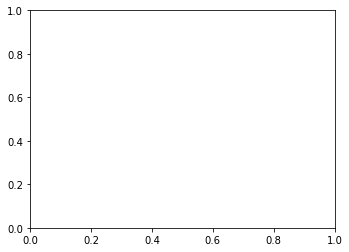

In [81]:
freq_df = count_words(twitter_data_cher)
plt.figure(figsize=(12,4))
plt.subplot(1,2,1)###
wordcloud(twitter_data_cher['tokens'], max_words=100)
plt.subplot(1,2,2)###
wordcloud(twitter_data_cher['tokens'], max_words=100, stopwords=freq_df.head(50).index)
#plt.tight_layout()###

freq_2015_df = count_words(df[df['year']==2015])
plt.figure(figsize=(12,4))
plt.subplot(1,2,1)###
wordcloud(freq_2015_df['freq'], max_words=100)
plt.subplot(1,2,2)###
wordcloud(freq_2015_df['freq'], max_words=100, stopwords=freq_df.head(50).index)
#plt.tight_layout()###

Q: What observations do you have about these (relatively straightforward) wordclouds? 

A: 